### Test calibration when smoothing predictions from MUSE

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats

def smooth_prediction(xgrid, ygrid, loc_estimate, std):
    distr = scipy.stats.multivariate_normal(
        mean=loc_estimate,
        cov=[[std, 0], [0, std]],
    )
    # get the probability density at each gridpoints
    pmf = distr.pdf(np.dstack((xgrid, ygrid)))
    # renormalize to be a valid pmf
    pmf /= pmf.sum()
    return pmf

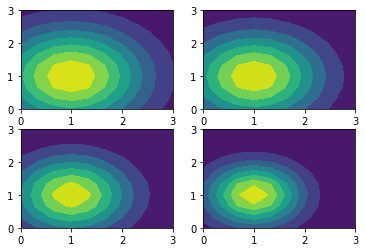

In [2]:
xgrid, ygrid = np.meshgrid(
    np.linspace(0, 3, 10),
    np.linspace(0, 3, 10)
)
smoothed_pred = lambda std: smooth_prediction(xgrid, ygrid, [1, 1], std)
fig, axs = plt.subplots(2, 2)
std_to_use = 1
for row in axs:
    for ax in row:
        ax.contourf(
            xgrid,
            ygrid,
            smoothed_pred(std_to_use)
            )
        std_to_use -= 0.2

In [3]:
def smooth_predictions(xgrid, ygrid, loc_estimates, std):
    pmf = np.zeros(xgrid.shape)
    for est in loc_estimates:
        pmf += smooth_prediction(xgrid, ygrid, est, std)
    pmf /= pmf.sum()
    return pmf

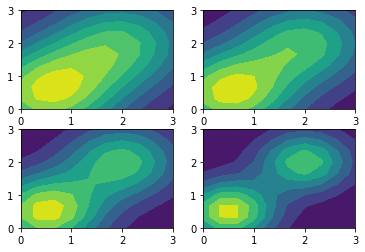

In [4]:
example_preds = [[0.5, 0.5], [2, 2]]
smoothed_by_std = lambda std: smooth_predictions(xgrid, ygrid, example_preds, std)
std_to_use = 1
fig, axs = plt.subplots(2, 2)
for row in axs:
    for ax in row:
        ax.contourf(
            xgrid,
            ygrid,
            smoothed_by_std(std_to_use)
            )
        std_to_use -= 0.2

plt.show()

simulate some data to work with for muse.

In [5]:
import muse
from scipy.io import wavfile
import glob

In [6]:
stimuli = []
sample_rates = []

for path in glob.glob('../tones/*.wav'):
    sr, stimulus = wavfile.read(path)
    stimuli.append(stimulus)
    sample_rates.append(sr)

In [7]:
print(stimuli[0].shape)

(96000,)


In [8]:
from pyroomacousticsutil import generate_dataset 

dataset = generate_dataset(stimuli, sample_rates, 0.25)

In [9]:
dataset[0].signal.shape

(4, 133924)

In [10]:
SIGMA = 0.5  # std for gaussian smoothing

from config import (
    X_DIM, Y_DIM, RESOLUTION, F_HI, F_LO, TEMP, MIC_POS
    )

xgrid, ygrid = muse.make_xy_grid(X_DIM, Y_DIM, resolution=RESOLUTION)

# avg_ests = []
# r_ests = []
# smoothed_preds = []
# for d in dataset:
#     avg_est, loc_ests, _ = muse.r_est_jackknife(
#         d.signal,
#         d.sample_rate,
#         F_LO,
#         F_HI,
#         TEMP,
#         X_DIM,
#         Y_DIM,
#         RESOLUTION,
#         MIC_POS
#     )
#     avg_ests.append(avg_est)
#     r_ests.append(loc_ests)
#     loc_ests = [est.reshape((2)) for est in loc_ests]
#     smoothed_preds.append(smooth_predictions(xgrid, ygrid, loc_ests, SIGMA))

That took literally forever. Even with the speedup. So let's pickle everything so we never have to do that again.

In [11]:
# import pickle

# with open('preds_with_offset.pickle', 'wb') as f:
#     pickle.dump((avg_ests, r_ests, smoothed_preds), f)

In [12]:
import pickle

with open('preds_with_offset.pickle', 'rb') as f:
    avg_ests, r_ests, smoothed_preds = pickle.load(f)

In [13]:
def pred_contour(idx, avg_ests, ests, preds):
    plt.contourf(xgrid, ygrid, preds[idx])
    true_location = dataset[idx].speaker_position
    avg_est, = plt.plot(avg_ests[idx][0], avg_ests[idx][1], 'bo')
    true_loc, = plt.plot(true_location[0], true_location[1], 'go')
    for est in ests[idx]:
        est_loc, = plt.plot(est[0], est[1], 'ro')
    plt.legend(
        [true_loc, avg_est, est_loc],
        ['True Location', 'Average Estimate', 'Jackknife Estimates']
        )
    plt.show()

In [14]:
smoothed_preds[0].shape

(97, 73)

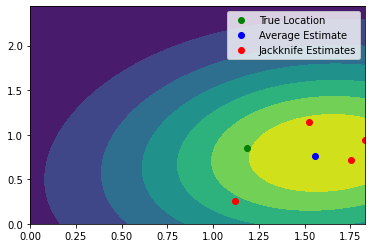

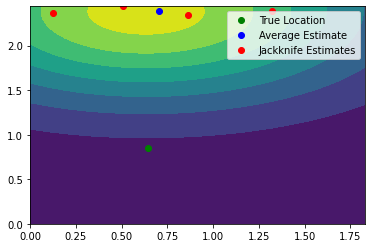

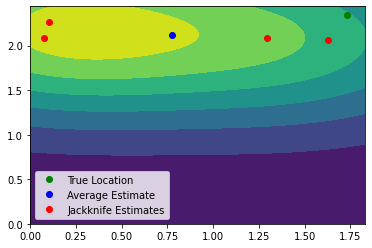

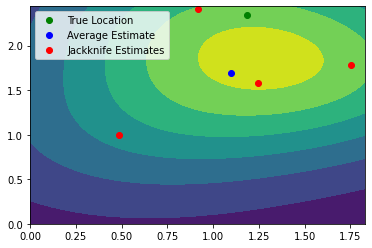

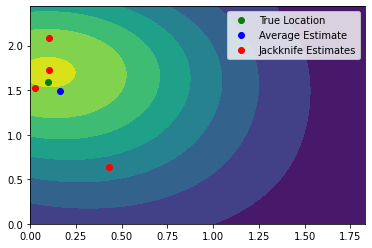

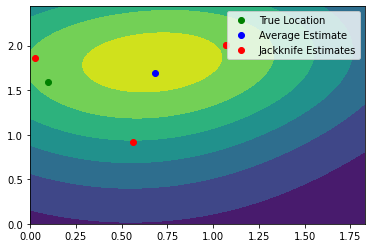

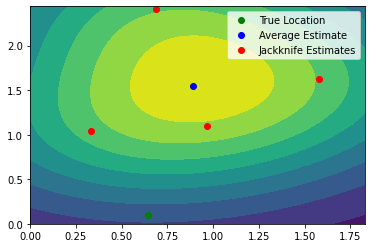

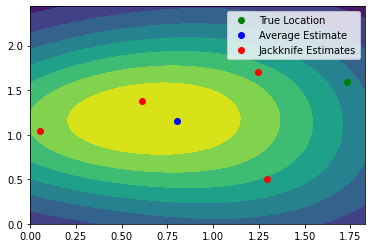

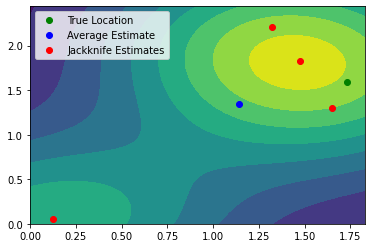

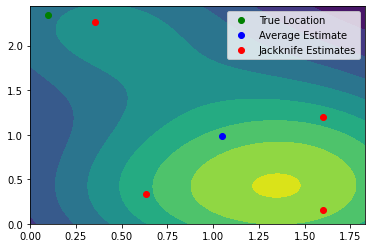

In [15]:
# take a look at some random data samples and the associated predictions
for i in np.random.randint(0, len(dataset), size=10):
    pred_contour(i, avg_ests, r_ests, smoothed_preds)

now attempt to test uncertainty

In [16]:
NUM_SAMPLES = len(dataset)
locations = np.array((X_DIM, Y_DIM))[np.newaxis, :].repeat(NUM_SAMPLES, axis=0)

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([0.01265823, 0.03797468, 0.05063291, 0.09493671, 0.13291139,
        0.15822785, 0.20886076, 0.24683544, 0.30379747, 1.        ]))

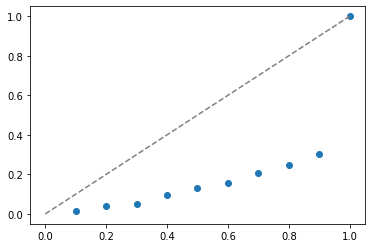

In [17]:
from calibration import calibration_curve

plt.rcParams['figure.facecolor'] = 'white'
calibration_curve(np.array(smoothed_preds), locations, xgrid, ygrid)

Guess we can't really interpret MUSE as outputting a probability distribution, even after applying Gaussian smoothing.

Let's try a new way to smooth the estimates. Rather than placing Gaussians at each jackknife estimate and arbitrarily choosing some $\sigma$, place one gaussian at the average estimated location, and set $\sigma$ to be the mean distance from that point to the jackknife estimates.

Why do this? Empirically, the individual jackknife estimates seem to be pretty inconsistent in their spread. The average estimate seems to be much more accurate generally than any individual point, so perhaps it makes more sense to center a gaussian at that average, then use the jackknifed estimates to determine the spread.

In [18]:
np.array(r_ests[0]).mean(axis=0)

array([[0.13979167],
       [0.1715625 ]])

In [19]:
np.linalg.norm(avg_ests[0] - r_ests[0], axis=1).mean()

0.1194262201960378

In [20]:
def alternate_smoothing(xgrid, ygrid, loc_estimates):
    smoothed = []
    for jackknife_pts in loc_estimates:
        avg_est = np.array(jackknife_pts).mean(axis=0)
        mean_distance = np.linalg.norm(avg_est - jackknife_pts, axis=1).mean()
        # collapse extra dimension in avg_est because scipy normal expects
        # a vector, not a (2, 1) array
        avg_est = avg_est.flatten()
        smoothed.append(smooth_prediction(xgrid, ygrid, avg_est, mean_distance))
    return smoothed

In [21]:
new_smoothing_results = alternate_smoothing(xgrid, ygrid, r_ests)

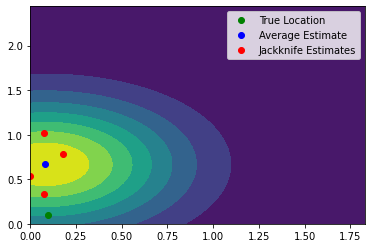

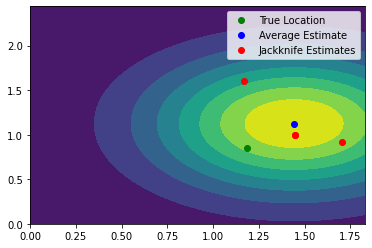

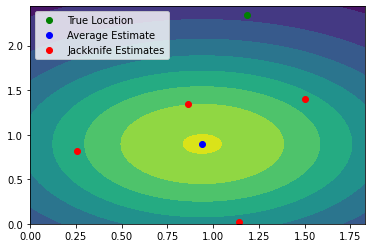

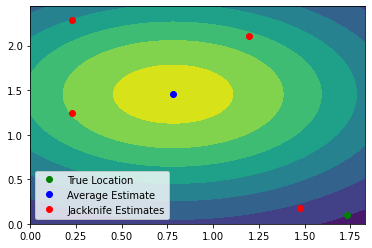

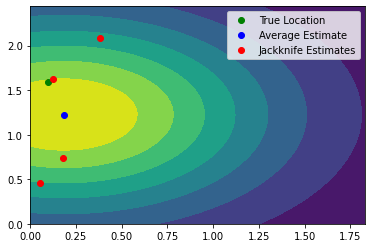

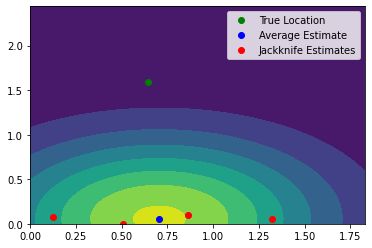

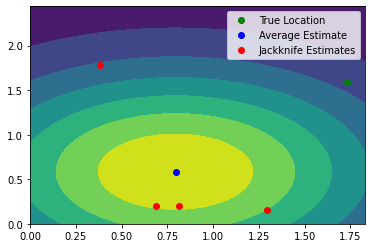

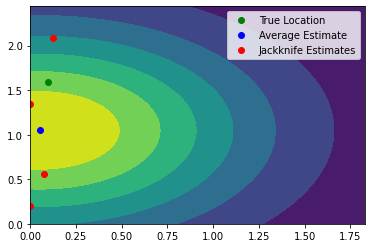

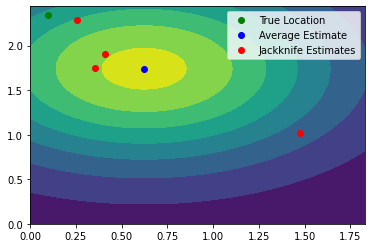

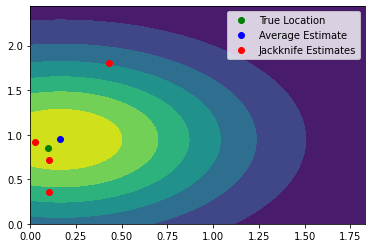

In [22]:
# take a look at some of the results
for i in np.random.randint(0, len(dataset), size=10):
    pred_contour(i, avg_ests, r_ests, new_smoothing_results)

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([0.        , 0.        , 0.00636943, 0.01910828, 0.02547771,
        0.03821656, 0.07643312, 0.12738854, 0.22292994, 1.        ]))

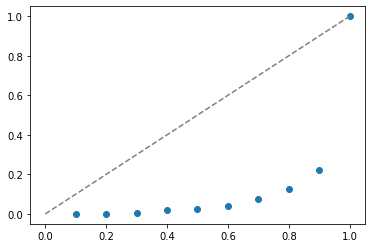

In [23]:
calibration_curve(np.array(new_smoothing_results), locations, xgrid, ygrid)

That failed spectacularly! Maybe we might have better results if we change the materials and reduce reverberations.

In [24]:
low_reverb_materials = {
    'ceiling': "curtains_fabric_folded",
    'floor': "curtains_fabric_folded",
    'east': "curtains_fabric_folded",
    'west': "curtains_fabric_folded",
    'north': "curtains_fabric_folded",
    'south': "curtains_fabric_folded"
}

low_reverb_dataset = generate_dataset(
    stimuli, sample_rates, 0.25, wall_materials=low_reverb_materials
    )

In [25]:
# low_reverb_avg_ests = []
# low_reverb_r_ests = []
# low_reverb_preds = []
# for d in low_reverb_dataset:
#     avg_est, loc_ests, _ = muse.r_est_jackknife(
#         d.signal,
#         d.sample_rate,
#         F_LO,
#         F_HI,
#         TEMP,
#         X_DIM,
#         Y_DIM,
#         RESOLUTION,
#         MIC_POS
#     )
#     low_reverb_avg_ests.append(avg_est)
#     low_reverb_r_ests.append(loc_ests)
#     loc_ests = [est.reshape((2)) for est in loc_ests]
#     low_reverb_preds.append(smooth_predictions(xgrid, ygrid, loc_ests, SIGMA))

In [26]:
# with open('low_reverb.pickle', 'wb') as f:
#     pickle.dump((
#         low_reverb_avg_ests, low_reverb_r_ests, low_reverb_preds
#         ), f)

In [27]:
with open('low_reverb.pickle', 'rb') as f:
    low_reverb_avg_ests, low_reverb_r_ests, low_reverb_preds = pickle.load(f)

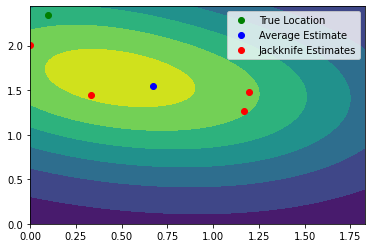

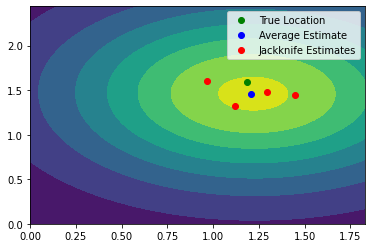

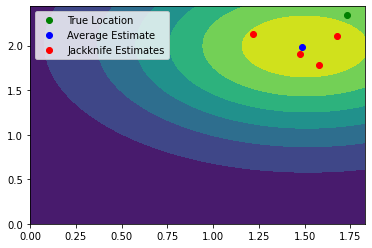

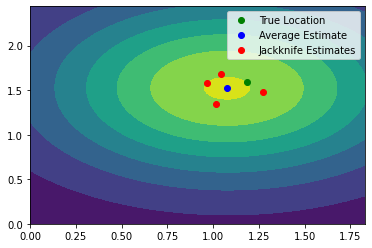

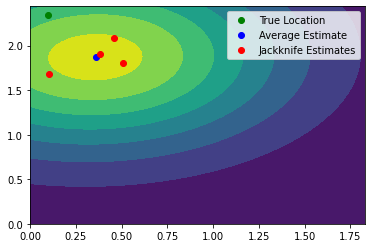

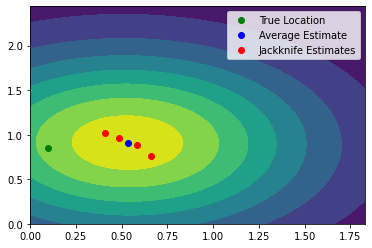

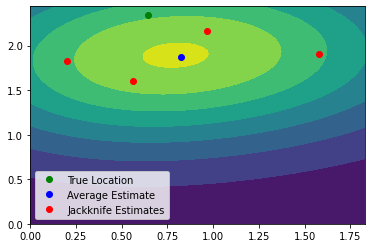

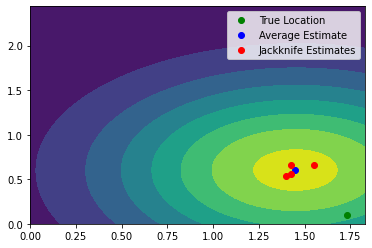

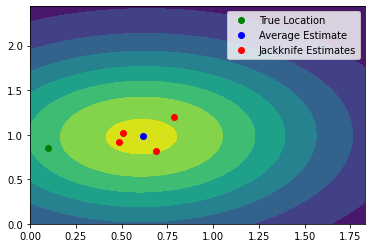

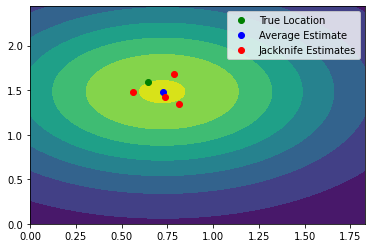

In [28]:
# first take a look at the predictions
# they should be much more accurate
for i in np.random.randint(0, len(low_reverb_dataset), size=10):
    pred_contour(i, low_reverb_avg_ests, low_reverb_r_ests, low_reverb_preds)

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([0.025  , 0.0625 , 0.1    , 0.225  , 0.36875, 0.4375 , 0.5    ,
        0.55625, 0.6375 , 1.     ]))

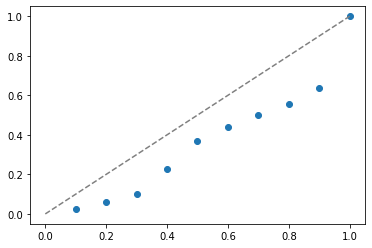

In [29]:
# now evaluate calibration
low_reverb_locations = np.array([d.speaker_position for d in low_reverb_dataset])
calibration_curve(np.array(low_reverb_preds), low_reverb_locations, xgrid, ygrid)

Interesting! Looks like in an optimal environment with the original gaussian smoothing, MUSE results can be interpreted somewhat probabilistically.

Now check the second method out of curiosity.

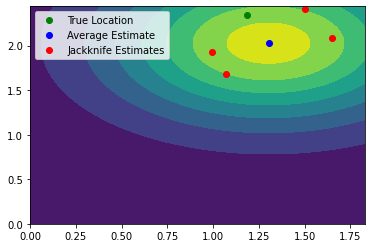

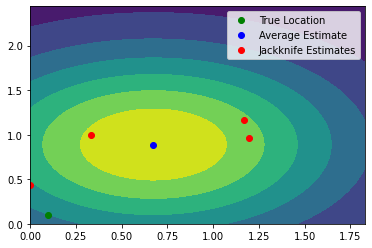

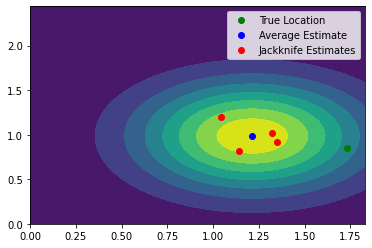

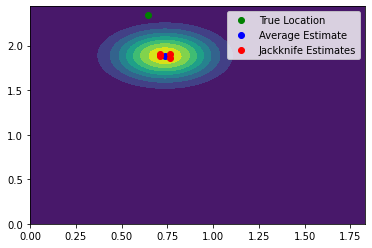

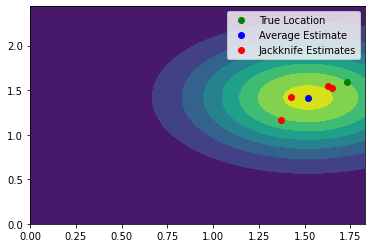

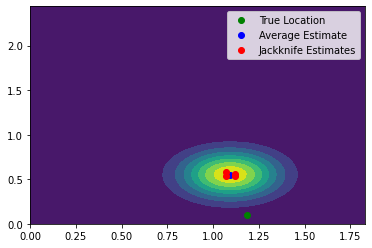

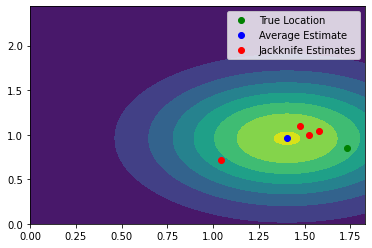

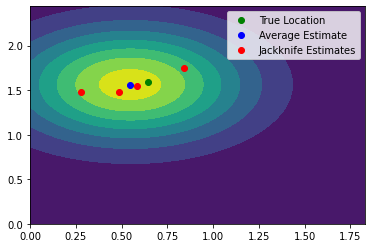

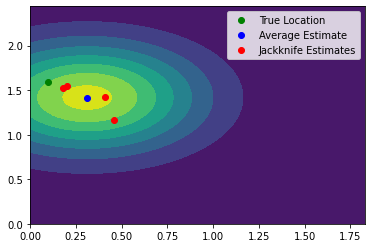

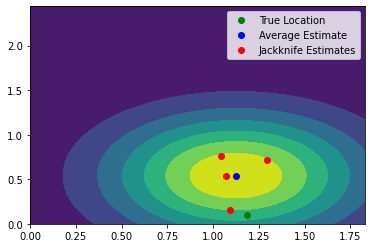

In [30]:
low_reverb_other_smoothing = alternate_smoothing(
    xgrid, ygrid, low_reverb_r_ests
)
for i in np.random.randint(0, len(low_reverb_dataset), size=10):
    pred_contour(i, low_reverb_avg_ests, low_reverb_r_ests, low_reverb_other_smoothing)

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([0.0125 , 0.03125, 0.075  , 0.1    , 0.1375 , 0.20625, 0.275  ,
        0.4    , 0.4625 , 1.     ]))

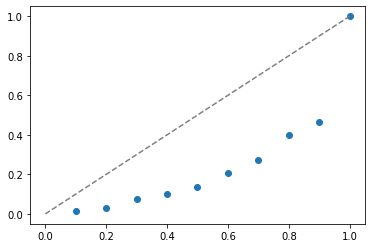

In [31]:
calibration_curve(
    np.array(low_reverb_other_smoothing),
    low_reverb_locations,
    xgrid,
    ygrid
    )

Clearly, the first smoothing method performs better across the board. Let's now try tuning the $\sigma$ parameter.

In [36]:
num_preds = len(low_reverb_r_ests)
tuning_set = low_reverb_r_ests[:int(0.8 * num_preds)]
tuning_locations = low_reverb_locations[:int(0.8 * num_preds)]

sigmas = np.linspace(0.1, 2, 10)
results = []

for sigma in sigmas:
    curr = []
    for preds in tuning_set:
        # reshape since scipy expects a vector,
        # not a (2, 1) array
        preds = [p.flatten() for p in preds]
        curr.append(smooth_predictions(
            xgrid, ygrid, preds, sigma
        ))
    results.append(curr)

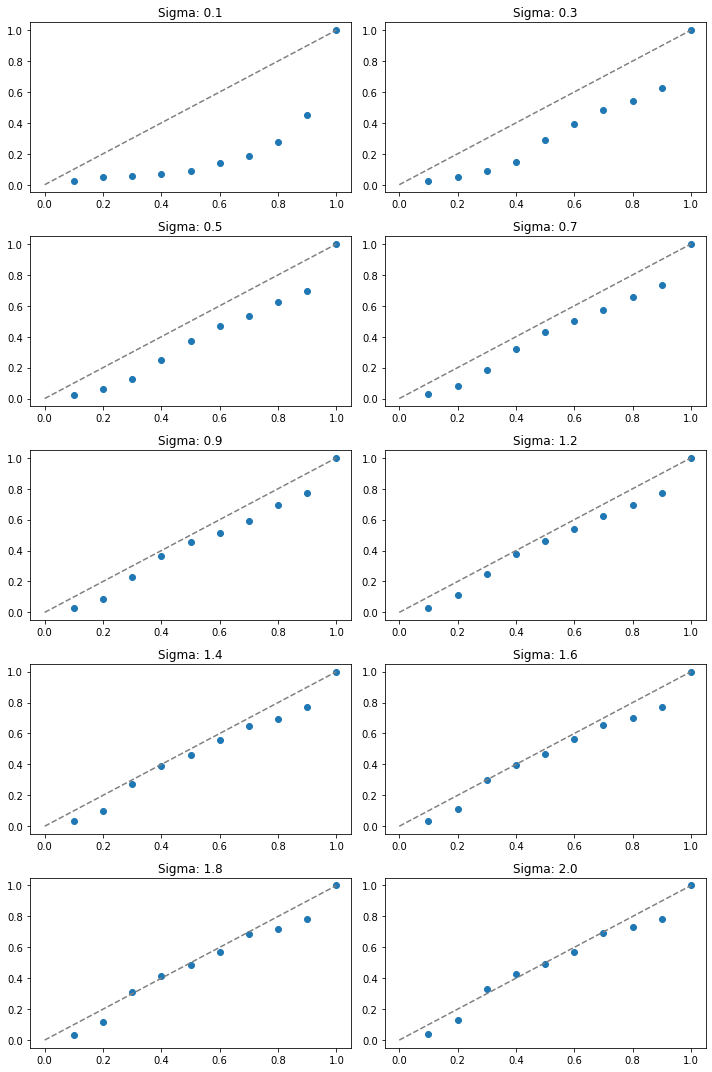

In [38]:
fig, axs = plt.subplots(5, 2, figsize=(10, 15))
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        idx = i * len(row) + j
        calibration_curve(
            np.array(results[idx]),
            tuning_locations,
            xgrid,
            ygrid,
            ax=ax
        )
        ax.set_title(f'Sigma: {sigmas[idx]:.1f}')
fig.tight_layout()
plt.show()

Empirically, it seems like calibration peaks at around sigma = 1. Check now the magnitude of our sigmas versus the maximum error in prediction.

In [57]:
mean_locs = np.array(low_reverb_avg_ests).reshape((-1, 2))
true_locs = low_reverb_locations[:, :2]  # remove height column
err = np.linalg.norm(mean_locs - true_locs, axis=1)

print(f'Max error: {err.max()} (m)')

Max error: 0.9759056735569047 (m)


In [97]:
test_large_sigma = [smooth_predictions(
            xgrid, ygrid, [r.flatten() for r in r_est], 100000
        ) for r_est in low_reverb_r_ests]

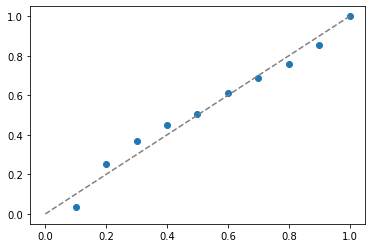

In [98]:
locs = np.array([ loc[:2] for loc in low_reverb_locations])
_, _ = calibration_curve(np.array(test_large_sigma), locs, xgrid, ygrid)

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([0.087, 0.212, 0.331, 0.44 , 0.544, 0.63 , 0.706, 0.774, 0.894,
        1.   ]))

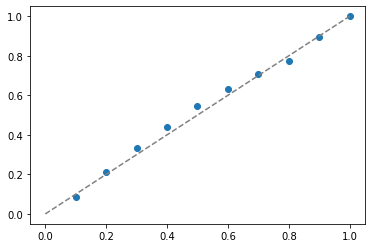

In [102]:
uniform_sampled = np.random.rand(1000,2)
xcoords = np.linspace(0, 1, 10)
ycoords = np.linspace(0, 1, 10)

xgrid, ygrid = np.meshgrid(xcoords, ycoords)

model_output = np.ones(xgrid.shape) * (1/100)
outputs = [model_output] * 1000

calibration_curve(np.array(outputs), uniform_sampled, xgrid, ygrid)

In [1]:
uniform_sampled = np.random.normal(loc=0.5, scale=0.1, size=(10000,2))
xcoords = np.linspace(0, 1, 10)
ycoords = np.linspace(0, 1, 10)

xgrid, ygrid = np.meshgrid(xcoords, ycoords)

model_output = np.ones(xgrid.shape) * (1/100)
outputs = [model_output] * 10000

calibration_curve(np.array(outputs), uniform_sampled, xgrid, ygrid)

NameError: name 'np' is not defined

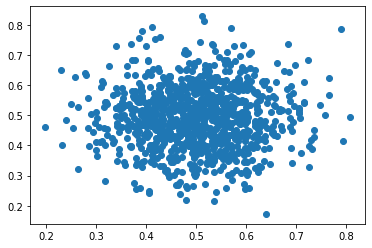

In [110]:
plt.scatter(uniform_sampled[:, 0], uniform_sampled[:, 1])

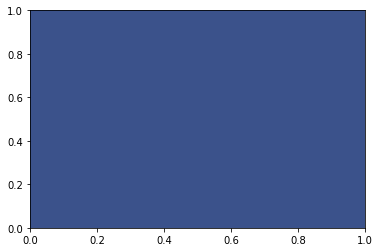

In [111]:
plt.contourf(xgrid, ygrid, model_output)

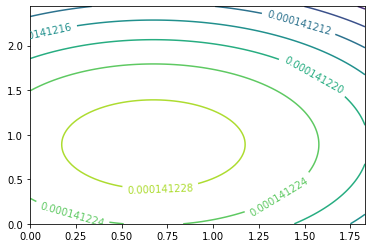

In [93]:
contour_set = plt.contour(xgrid, ygrid, test_large_sigma[0])
plt.clabel(contour_set)
# true_location = dataset[idx].speaker_position
# avg_est, = plt.plot(avg_ests[idx][0], avg_ests[idx][1], 'bo')
# true_loc, = plt.plot(true_location[0], true_location[1], 'go')
# for est in ests[idx]:
#     est_loc, = plt.plot(est[0], est[1], 'ro')
# plt.legend(
#     [true_loc, avg_est, est_loc],
#     ['True Location', 'Average Estimate', 'Jackknife Estimates']
#     )
plt.show()

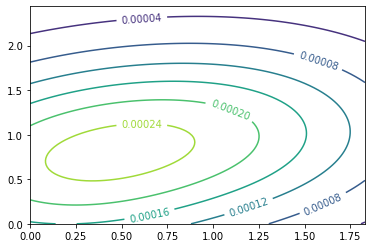

In [94]:
contour_set = plt.contour(xgrid, ygrid, low_reverb_preds[0])
plt.clabel(contour_set)
plt.show()

In [ ]:
low_reverb_ests[0]

In [91]:
test_large_sigma[0].sum()

1.0000000000000002

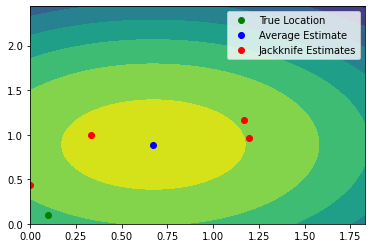

In [88]:
pred_contour(0, low_reverb_avg_ests, low_reverb_r_ests, test_large_sigma)

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([0.03125, 0.1625 , 0.35625, 0.43125, 0.48125, 0.575  , 0.6375 ,
        0.74375, 0.85   , 1.     ]))

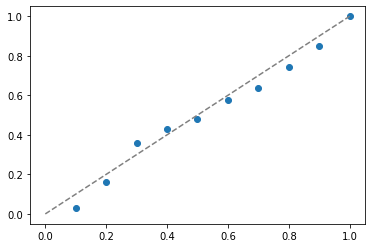

In [80]:
locs = np.array([ loc[:2] for loc in low_reverb_locations])
_, _ = calibration_curve(np.array(test_large_sigma), locs, xgrid, ygrid)

Visualize some of these functions.

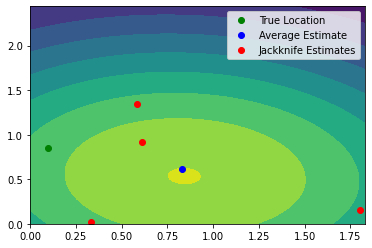

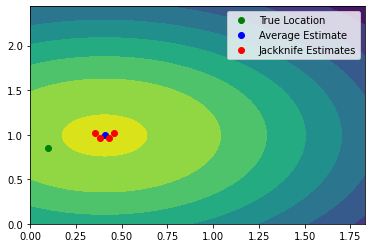

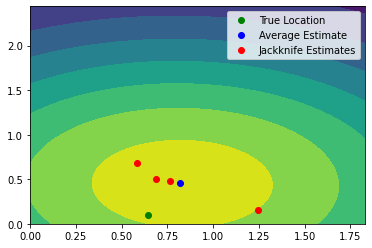

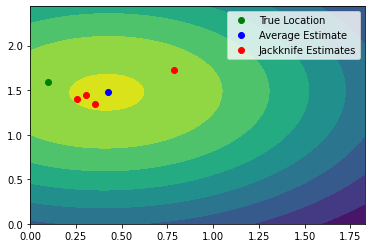

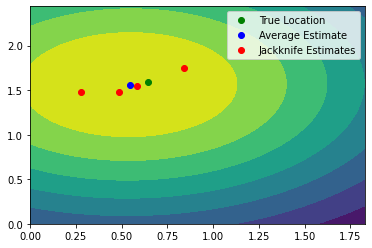

In [39]:
# sigma = 2
for i in np.random.randint(0, len(tuning_set), size=5):
    pred_contour(i, low_reverb_avg_ests, low_reverb_r_ests, results[-1])

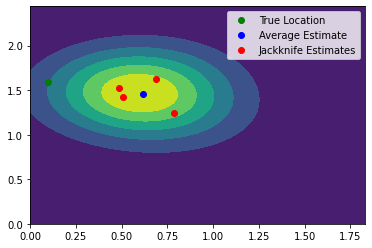

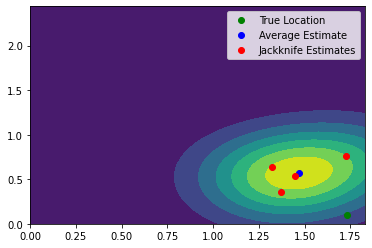

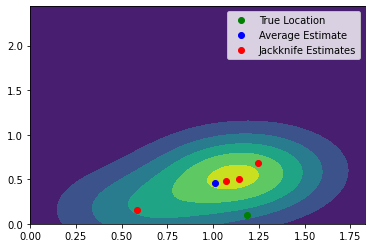

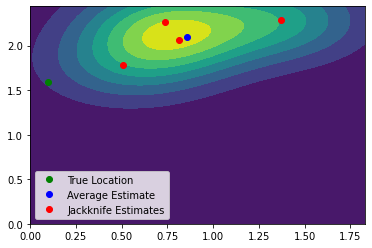

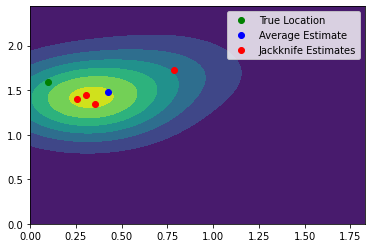

In [40]:
# sigma = 0.1
for i in np.random.randint(0, len(tuning_set), size=5):
    pred_contour(i, low_reverb_avg_ests, low_reverb_r_ests, results[0])

Possible conclusion: Perhaps the spread of the Jackknife estimates don't really reflect the uncertainty of the model at all. Look into this! Accuracy versus some measure of spread of the estimates?

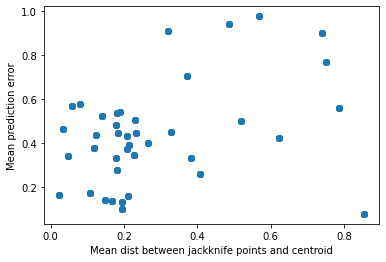

In [56]:
# let our spread measure be the average distance from the centroid

def mean_dist_from_centroid(jackknife_estimates):
    dists = []
    for r_ests in jackknife_estimates:
        avg_est = np.array(r_ests).mean(axis=0)
        mean_distance = np.linalg.norm(avg_est - r_ests, axis=1).mean()
        dists.append(mean_distance)
    return dists

# and let accuracy be the distance between the average estimate and the true location

mean_locs = np.array(low_reverb_avg_ests).reshape((-1, 2))
true_locs = low_reverb_locations[:, :2]  # remove height column
accuracy = np.linalg.norm(mean_locs - true_locs, axis=1)

spread = mean_dist_from_centroid(low_reverb_r_ests)

plt.scatter(spread, accuracy)
plt.xlabel('Mean dist between jackknife points and centroid')
plt.ylabel('Mean prediction error')
plt.show()